### Inciso 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from numpy import random
import functools
import scipy.stats as st

In [2]:
data = np.genfromtxt('puntos')
data_inf = np.genfromtxt('puntos inferiores')
data_sup = np.genfromtxt('puntos superiores')

In [3]:
print(len(data),len(data_inf),len(data_sup))

47 47 47


In [4]:
x_lista = []
y_lista = []
y_lista_inf = []
y_lista_sup = []

for i in range(len(data)):
    x = data[i][0]
    y = data[i][1]
    y_inf = data_inf[i][1]
    y_sup = data_sup[i][1]
    x_lista.append(x)
    y_lista.append(y) 
    y_lista_sup.append(y_sup)
    y_lista_inf.append(y_inf)

In [5]:
barra_y_sup = np.array(y_lista_sup)
barra_y_inf = np.array(y_lista_inf)
barra_y = np.array(y_lista)

In [6]:
barra_sup = barra_y_sup - barra_y
barra_inf = barra_y - barra_y_inf

In [7]:
barras = [barra_inf, barra_sup] 

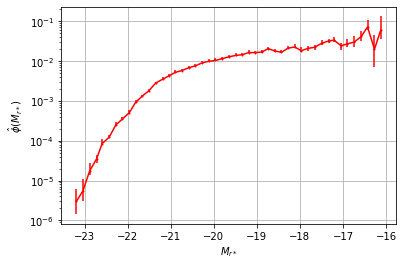

In [8]:
plt.scatter(x_lista,y_lista, s=1, c = 'red')
plt.errorbar(x_lista, y_lista, yerr=barras, c = 'red')
plt.yscale('log')
plt.ylabel('$\hat{\phi} (M_{r*})$')
plt.xlabel('$M_{r*}$')
plt.grid()

### Inciso 2

In [9]:
def modelo(phi0,X,M0,alpha):
    
    modelo_lista = []
    A = np.array(X)
    
    for i in range(len(A)):
        C = (-0.4) * (A[i]-M0) * (alpha+1)
        B = (-0.4) * (A[i]-M0)
        phi = 0.4 * np.log(10) * phi0 * (10**C) * np.exp(-10**B)
        modelo_lista.append(phi)
    return(modelo_lista)

In [10]:
y = modelo(1.46e-2,x_lista,-20.83,-1.20)

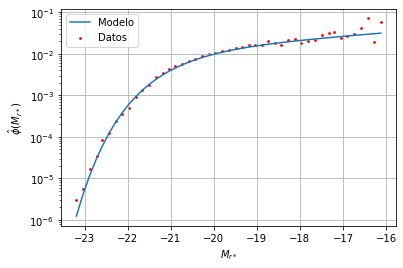

In [11]:
plt.plot(x_lista,y,label='Modelo')
plt.yscale('log')
plt.scatter(x_lista,y_lista, s=3, c = 'red',label='Datos')
#plt.errorbar(x_lista, y_lista, yerr=barras, c = 'red')
plt.ylabel('$\hat{\phi} (M_{r*})$')
plt.xlabel('$M_{r*}$')
plt.legend()
plt.grid()

Ahora calculamos el Likelihood

In [12]:
def likelihood(X,Y,sigma,a,b,c):
    y_modelo = modelo(a,X,b,c)
    lista_likelihood = []
    for i in range(len(X)):
        p = norm.pdf(Y[i],y_modelo[i],sigma[i])
        lista_likelihood.append(p)
        
    return(np.prod(lista_likelihood))

In [13]:
intervalo_lista = []

for i in range(len(barra_y_sup)):
    intervalo = (barra_sup[i] + barra_inf[i])*0.5
    intervalo_lista.append(intervalo)

In [14]:
likelihood(x_lista,y_lista,intervalo_lista,1.46e-2,-20.83,-1.20)

2.908342530234035e+120

Ahora hagamos el Prior

In [15]:
def prior1(phi=1.46e-2,a=-1.2, M=-20.83,phi_inf =9e-3,phi_sup=2.4E-2,a_sup=-0.9,a_inf=-1.5,M_sup=-20.55,M_inf=-21.1):
    
    delta_phi = phi_sup - phi_inf
    delta_alpha = a_sup -a_inf
    delta_M = M_sup - M_inf
#     recordar que deben ser positivos los scale, o arreglarlo con abs()
    f = st.uniform(loc = [ phi_inf, a_inf, M_inf], scale = [delta_phi, delta_alpha, delta_M])
    p = f.pdf([phi, a, M]).prod()
#     esto porque debemos hacer el producto de los 1 / scale(i), que me da el volumen
# los _inf y _sup son los limites inferiores y superiores de los parametros, el uniform se centra en el _inf, 
# con scale = amplitud del intervalo de cada parametro
# phi, a y M son los valores que queremos probar si se encuentran dentro del cubo de parametros
    return(p)

Para darle valores de $M_{max}$, $M_{min}$, $\phi_{max}$, $\phi_{min}$, $\alpha_{max}$, $\alpha_{min}$ tenemos que definir límites de la función a ojo, ya que no tenemos información de Galaxias como para inferir cuales podrían ser.

In [16]:
#phi_max = 2.4e-2
#phi_min = 9e-3
#M_max = -21.1
#M_min = -20.55
#alpha_max = -1.5
#alpha_min = -0.9

#valores propuestos por pato

phi_max = 4e-3
phi_min = 4e-4
M_max = -19.9
M_min = -21.9
alpha_max = -1.9
alpha_min = -1e-4

y = modelo(1.46e-2,x_lista,-20.83,-1.20)
y1 = modelo(phi_max,x_lista,-20.83,-1.20)
y2 = modelo(phi_min,x_lista,-20.83,-1.20)
y3 = modelo(1.46e-2,x_lista,M_max,-1.20)
y4 = modelo(1.46e-2,x_lista,M_min,-1.20)
y5 = modelo(1.46e-2,x_lista,-20.83,alpha_max)
y6 = modelo(1.46e-2,x_lista,-20.83,alpha_min)

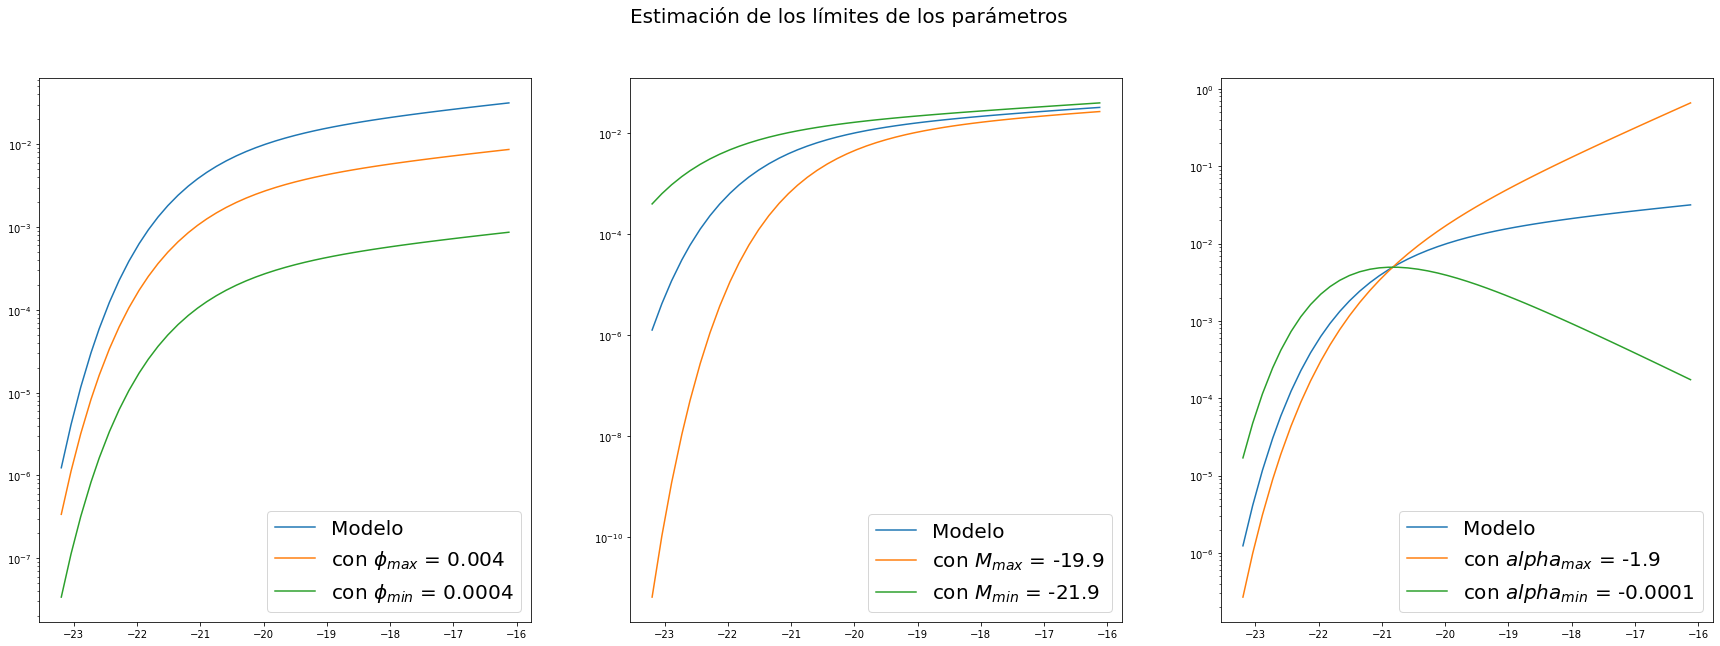

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
fig.suptitle('Estimación de los límites de los parámetros', fontsize=20)

ax1.plot(x_lista,y,label='Modelo')
ax1.plot(x_lista,y1,label='con $\phi_{max}$ = '+str(phi_max))
ax1.plot(x_lista,y2,label='con $\phi_{min}$ = '+str(phi_min))
ax1.set_yscale('log')
ax1.legend(loc = 'lower right',fontsize=20)

ax2.plot(x_lista,y,label='Modelo')
ax2.plot(x_lista,y3,label='con $M_{max}$ = '+str(M_max))
ax2.plot(x_lista,y4,label='con $M_{min}$ = '+str(M_min))
ax2.set_yscale('log')
ax2.legend(loc = 'lower right',fontsize=20)

ax3.plot(x_lista,y,label='Modelo')
ax3.plot(x_lista,y5,label = 'con $alpha_{max}$ = '+str(alpha_max))
ax3.plot(x_lista,y6,label = 'con $alpha_{min}$ = '+str(alpha_min))
ax3.set_yscale('log')
ax3.legend(loc = 'lower right',fontsize=20)

fig.subplots_adjust(wspace=0.2)
plt.show()

In [18]:
prior1(phi=1.46e-2,a=-1.2, M=-20.83,phi_inf = 0.0004, phi_sup = 0.04, a_inf = -1.9, a_sup = -0.0001, M_inf = -21.9, M_sup = -19.7)

6.041591962382053

In [19]:
prior2b = functools.partial(prior1,phi_inf = 0.0004, phi_sup = 0.04, a_inf = -1.9, a_sup = -0.0001, M_inf = -21.9, M_sup = -19.7)

In [20]:
prior2b(phi=1.46e-2,a=-1.2, M=-20.83)

6.041591962382053

In [21]:
def posterior(x_lista,y_lista,intervalo_lista,phi0,M0,alpha0):
    p = likelihood(x_lista,y_lista,intervalo_lista,phi0,M0,alpha0)
    q = prior2b(phi0,alpha0, M0)
    return(q*p)

In [22]:
posterior(x_lista,y_lista,intervalo_lista,1.46e-2,-20.83,-1.20)

1.7571018854515828e+121

Antes de empezar con las cadenas, construimos la proposal distribution. Esta será la que definirá el salto de cada parámetro para construir la cadena.

In [39]:
def d_propuesta(M0, phi0, alpha0):

    c1 = 0.002
    c2 = 0.00002
    c3 = 0.0002
    
    d1 = random.normal(loc=M0, scale=(c1))
    d2 = random.normal(loc=phi0, scale=(c2))
    d3 = random.normal(loc=alpha0, scale=(c3))

    return([d1, d2, d3])

In [41]:
d_propuesta(-20.83, 1.46e-2, -1.2)

[-20.833065214942543, 0.01457657851481586, -1.2001765116990566]

In [45]:
#iniciamos la cadena

post = 0

while post < 1e-8:
    
    M0 = random.uniform(-21.9,-19.9)
    phi0 = random.uniform(4e-4,4e-2)
    alpha0 = random.uniform(-1.9,-1e-4)
    
    post = posterior(x_lista,y_lista,intervalo_lista,phi0,M0,alpha0)

    prob_posterior = post

pasos = 1e+4
pasos = int(pasos)

cadena_M = []
cadena_phi = []
cadena_alpha = []



for i in range(pasos):
    salto = d_propuesta(M0, phi0, alpha0)
    
    M_n = salto[0]
    phi_n = salto[1]
    alpha_n = salto[2]
    
    prob_posterior_n = posterior(x_lista,y_lista,intervalo_lista,phi_n,M_n,alpha_n)
    
    prob_aceptacion = min(1,(prob_posterior_n/prob_posterior))
    u = random.uniform()
    
    if u < prob_aceptacion:
        M0 = M_n
        alpha0 = alpha_n
        phi0 = phi_n
        prob_posterior = prob_posterior_n
        
    cadena_M.append(M0)
    cadena_phi.append(phi0)
    cadena_alpha.append(alpha0)

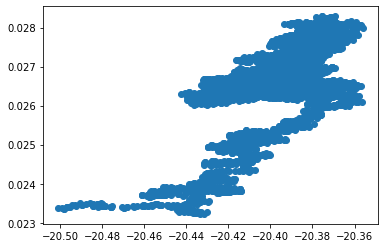

In [46]:
plt.scatter(cadena_M, cadena_phi)

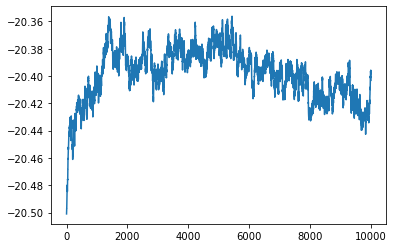

In [50]:
plt.plot(cadena_M)